In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
random_seed = 42

In [59]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, roc_auc_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

In [60]:
train_data = pd.read_csv("./playground-series-s4e8/train.csv")
test_data = pd.read_csv("./playground-series-s4e8/test.csv")

In [61]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [62]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [63]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


In [64]:
# getting the percentage of null records
def get_null(df):
    null_sum = df.isnull().sum()
    null_df = pd.DataFrame(null_sum, columns = ["null_sum"])
    null_df['null_perc'] = null_df["null_sum"].apply(lambda x : (x/train_data.shape[0])*100)
    return null_df.sort_values(by="null_perc", ascending=False)

In [65]:
train_data.duplicated().sum()

0

In [66]:
# for convenience
train_data.rename(columns=lambda x: x.replace("-", "_"), inplace=True)
test_data.rename(columns=lambda x: x.replace("-", "_"), inplace=True)

In [67]:
# some columns are not having correct labels - converting them
valid_col_vals = {
    "cap_shape": ['b', 'c', 'x', 'f', 'k', 's'],
    "cap_surface": ['f', 'g', 'y', 's'],
    "cap_color": ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
    "does_bruise_or_bleed": ['t', 'f'],
    "has_ring": ['t', 'f'],
    "odor": ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'],  # 'n' indicates 'none'
    "gill_attachment": ['a', 'd', 'f', 'n'],
    "gill_spacing": ['c', 'w', 'd'],
    "gill_size": ['b', 'n'],
    "gill_color": ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
    "stalk_shape": ['e', 't'],
    "stem_root": ['b', 'c', 'u', 'e', 'z', 'r', '?'],  # '?' indicates missing
    "stem_surface": ['f', 'y', 'k', 's'],
    "stem_color": ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
    "veil_type": ['p', 'u'],
    "veil_color": ['n', 'o', 'w', 'y'],
    "ring_number": ['n', 'o', 't'],  # 'n' indicates 'none'
    "ring_type": ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],  # 'n' indicates 'none'
    "spore_print_color": ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y'],
    "population": ['a', 'c', 'n', 's', 'v', 'y'],
    "habitat": ['g', 'l', 'm', 'p', 'u', 'w', 'd']
}

In [68]:
invalid_indices = train_data.index[train_data['cap_shape'].apply(lambda x: x not in valid_col_vals['cap_shape'])]

In [69]:
invalid_indices

Index([      6,      15,      17,      29,      32,      56,      81,     104,
           105,     127,
       ...
       3116814, 3116815, 3116826, 3116847, 3116868, 3116884, 3116896, 3116915,
       3116939, 3116943],
      dtype='int64', length=216356)

In [70]:
# if there are values other than the above mentioned values in the column we may need to remove those 
# or convert those
def transform_cat_cols(df):
    for col in df.columns:
        if col in ['odor', 'ring_number', 'ring_type']:
            invalid_indices = df.index[df[col].apply(lambda x: x not in valid_col_vals[col])]
            df.loc[invalid_indices, col] = 'n'
        elif col in ['stem_root']:
            invalid_indices = df.index[df[col].apply(lambda x: x not in valid_col_vals[col])]
            df.loc[invalid_indices, col] = '?'
        elif col in valid_col_vals.keys():
            invalid_indices = df.index[df[col].apply(lambda x: x not in valid_col_vals[col])]
            df.loc[invalid_indices, col] = 'unk'
    return df

In [71]:
train_data = transform_cat_cols(train_data)
test_data = transform_cat_cols(test_data)

In [72]:
null_train = get_null(train_data)
null_train

,null_sum,null_perc
cap_diameter,4,0.000128
id,0,0.000000
stem_root,0,0.000000
habitat,0,0.000000
spore_print_color,0,0.000000
ring_type,0,0.000000
has_ring,0,0.000000
veil_color,0,0.000000
veil_type,0,0.000000
stem_color,0,0.000000


In [73]:
null_test = get_null(test_data)
null_test

,null_sum,null_perc
cap_diameter,7,0.000225
stem_height,1,0.000032
id,0,0.000000
stem_surface,0,0.000000
habitat,0,0.000000
spore_print_color,0,0.000000
ring_type,0,0.000000
has_ring,0,0.000000
veil_color,0,0.000000
veil_type,0,0.000000


In [74]:
miss_col = []
miss_col.append(null_train[null_train['null_perc'] > 0].index.tolist())
miss_col.append(null_test[null_test['null_perc'] > 0].index.tolist())

In [75]:
print(miss_col)

[['cap_diameter'], ['cap_diameter', 'stem_height']]


In [76]:
miss_col = set(item for sublist in miss_col for item in sublist)
print(miss_col)

{'stem_height', 'cap_diameter'}


In [77]:
# handling missing data
def handle_missing_data(df, miss_col):
    for col in miss_col:
        df[col] = df[col].fillna(df[col].mean())
    
    return df

In [78]:
train_data = handle_missing_data(train_data, miss_col)
test_data = handle_missing_data(test_data, miss_col)

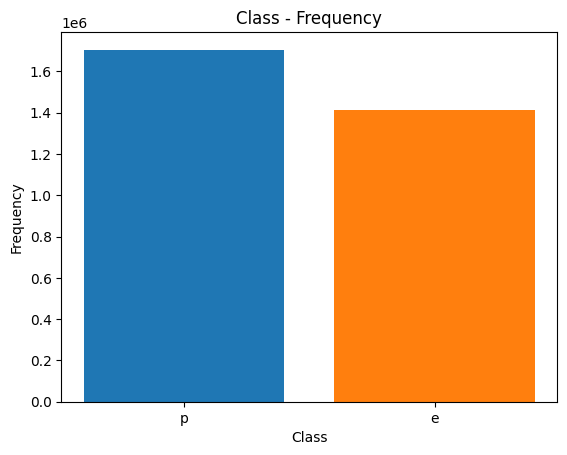

In [79]:
df_col = train_data['class'].value_counts()

palette = sns.color_palette("tab10", len(df_col))
colors = [palette[i] for i in range(len(df_col))]

plt.bar(df_col.index, df_col.values, color=colors)

plt.title("Class - Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.show()

In [80]:
train_data.drop(['id'], axis = 1, inplace=True)
test_ids = test_data['id']
test_data.drop(['id'], axis = 1, inplace=True)

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap_diameter          float64
 2   cap_shape             object 
 3   cap_surface           object 
 4   cap_color             object 
 5   does_bruise_or_bleed  object 
 6   gill_attachment       object 
 7   gill_spacing          object 
 8   gill_color            object 
 9   stem_height           float64
 10  stem_width            float64
 11  stem_root             object 
 12  stem_surface          object 
 13  stem_color            object 
 14  veil_type             object 
 15  veil_color            object 
 16  has_ring              object 
 17  ring_type             object 
 18  spore_print_color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [82]:
# need to encode the categorical data and standardize numerical columns
numerical_cols = train_data.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

In [83]:
print(numerical_cols)

['cap_diameter', 'stem_height', 'stem_width']


In [84]:
print(categorical_cols)

['class', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season']


In [85]:
scaler = StandardScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

In [86]:
label_encoders = {}

for col in categorical_cols:
    if col != "class":
        label_encoder = LabelEncoder()
        train_data[col] = label_encoder.fit_transform(train_data[col])
        label_encoders[col] = label_encoder
        test_data[col] = label_encoder.transform(test_data[col])

print("Transformed Train Data:")
print(train_data.head())
print("\nTransformed Test Data:")
print(test_data.head())

Transformed Train Data:
  class  cap_diameter  cap_shape  cap_surface  cap_color  \
0     e      0.534605          2            2          7   
1     p     -0.386405          6            3          8   
2     e      0.135286          2            2          0   
3     e     -0.521659          2            4          3   
4     e     -0.098724          6            3          9   

   does_bruise_or_bleed  gill_attachment  gill_spacing  gill_color  \
0                     0                0             0          11   
1                     0                0             0           5   
2                     0                4             0          11   
3                     0                4             2           2   
4                     0                1             2          11   

   stem_height  ...  stem_root  stem_surface  stem_color  veil_type  \
0    -0.680926  ...          0             3           8          2   
1    -0.577213  ...          0             4        

In [87]:
train_data['class'] = train_data['class'].map({'e':1,'p':0})

In [88]:
x = train_data.drop('class', axis=1)
y = train_data['class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed)

In [89]:
class classificationModel:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        
    def model_training(self):
        self.model.fit(self.X_train, self.y_train)
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)
        y_test_prob = self.model.predict_proba(self.X_test)[:, 1]
        
        return y_train_pred, y_test_pred, y_test_prob
        
    
    def model_evaluation(self, train_pred, test_pred, test_prob):
        train_acc = accuracy_score(self.y_train, train_pred)*100
        test_acc = accuracy_score(self.y_test, test_pred)*100
        test_f1 = f1_score(self.y_test, test_pred)
        test_pre = precision_score(self.y_test, test_pred)
        test_recall = recall_score(self.y_test, test_pred)
        test_roc_auc = roc_auc_score(self.y_test, test_prob)
        
        print(f"Model : {self.model}")
        print(f"Accuracy of Training Data: {train_acc}")
        print(f"Accuracy of Testing Data: {test_acc}")
        print(f"F1 Score of Testing Data: {test_f1}")
        print(f"Pecision of Testing Data: {test_pre}")
        print(f"Recall of Testing Data: {test_recall}")
        print(f"ROC AUC of Testing Data: {test_roc_auc}")
        print("\n***CLASSIFICATION REPORT***\n")
        print(classification_report(self.y_test, test_pred))

### Logistic Regression

In [90]:
# Logistic Regression
log_model = LogisticRegression(solver='liblinear', random_state=random_seed)
log_classification = classificationModel(log_model, X_train, X_test, y_train, y_test)

In [91]:
%%time
# Logistic Regression Traning
train_pred, test_pred, test_prob = log_classification.model_training()

CPU times: user 37.1 s, sys: 1.39 s, total: 38.5 s
Wall time: 38.8 s


In [92]:
%%time
log_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : LogisticRegression(random_state=42, solver='liblinear')
Accuracy of Training Data: 65.96314660669341
Accuracy of Testing Data: 65.89416880952342
F1 Score of Testing Data: 0.5983815273485609
Pecision of Testing Data: 0.6412703296881263
Recall of Testing Data: 0.560869980913395
ROC AUC of Testing Data: 0.7306448320214269

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.67      0.74      0.70    340992
           1       0.64      0.56      0.60    282397

    accuracy                           0.66    623389
   macro avg       0.66      0.65      0.65    623389
weighted avg       0.66      0.66      0.66    623389

CPU times: user 2.9 s, sys: 245 ms, total: 3.14 s
Wall time: 2.33 s


### GradientBoostingClassifier

In [93]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=random_seed)
gb_classification = classificationModel(gb_model, X_train, X_test, y_train, y_test)

In [94]:
%%time
# Gradient Boosting Traning
train_pred, test_pred, test_prob = gb_classification.model_training()

CPU times: user 7min 9s, sys: 6.39 s, total: 7min 16s
Wall time: 7min 25s


In [95]:
%%time
gb_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : GradientBoostingClassifier(random_state=42)
Accuracy of Training Data: 90.4530317345991
Accuracy of Testing Data: 90.34342922316563
F1 Score of Testing Data: 0.8919447715327838
Pecision of Testing Data: 0.904429082622576
Recall of Testing Data: 0.8798004228090242
ROC AUC of Testing Data: 0.9661325944430468

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.90      0.92      0.91    340992
           1       0.90      0.88      0.89    282397

    accuracy                           0.90    623389
   macro avg       0.90      0.90      0.90    623389
weighted avg       0.90      0.90      0.90    623389

CPU times: user 2.01 s, sys: 90.2 ms, total: 2.1 s
Wall time: 2.11 s


### XGB Classifer

In [96]:
# XGBoost
xgb_model = XGBClassifier(random_state=random_seed)
xgb_classification = classificationModel(xgb_model, X_train, X_test, y_train, y_test)

In [97]:
%%time
# XGBoost Traning
train_pred, test_pred, test_prob = xgb_classification.model_training()

CPU times: user 48.4 s, sys: 8.16 s, total: 56.6 s
Wall time: 11.6 s


In [98]:
%%time
xgb_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Accuracy of Training Data: 98.97993066929317
Accuracy of Testing Data: 98.93421282698283
F1 Score of Testing Data: 0.988254386926376
Pecision of Testing Data: 0.9867472048746563
Recall of Testing Data: 0.9897661802356257
ROC AUC of Test

### Random Forest

In [99]:
# Random Forest
rf_model = RandomForestClassifier(random_state=random_seed)
rf_classification = classificationModel(rf_model, X_train, X_test, y_train, y_test)

In [100]:
%%time
# Random Forest Traning
train_pred, test_pred, test_prob = rf_classification.model_training()

CPU times: user 8min 49s, sys: 7.27 s, total: 8min 56s
Wall time: 9min 10s


In [101]:
%%time
rf_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : RandomForestClassifier(random_state=42)
Accuracy of Training Data: 99.99851617529345
Accuracy of Testing Data: 99.10008036715438
F1 Score of Testing Data: 0.990076311571976
Pecision of Testing Data: 0.9891664339718009
Recall of Testing Data: 0.9909878646019611
ROC AUC of Testing Data: 0.995869908490824

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    340992
           1       0.99      0.99      0.99    282397

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

CPU times: user 1.95 s, sys: 34.7 ms, total: 1.98 s
Wall time: 1.98 s


### CatBoost

In [102]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=100
)

In [103]:
catboost_classification = classificationModel(catboost_model, X_train, X_test, y_train, y_test)

In [104]:
%%time
train_pred_cat, test_pred_cat, test_prob_cat = catboost_classification.model_training()

0:	learn: 0.6701785	total: 253ms	remaining: 2m 6s
100:	learn: 0.1601112	total: 38s	remaining: 2m 30s
200:	learn: 0.0843051	total: 1m 15s	remaining: 1m 52s
300:	learn: 0.0608551	total: 1m 54s	remaining: 1m 15s
400:	learn: 0.0522780	total: 2m 39s	remaining: 39.3s
499:	learn: 0.0484375	total: 3m 22s	remaining: 0us
CPU times: user 13min 18s, sys: 12.7 s, total: 13min 30s
Wall time: 3min 25s


In [105]:
%%time
catboost_classification.model_evaluation(train_pred_cat, test_pred_cat, test_prob_cat)

Model : <catboost.core.CatBoostClassifier object at 0x10990dc10>
Accuracy of Training Data: 98.89037984308354
Accuracy of Testing Data: 98.85801642313227
F1 Score of Testing Data: 0.9874112518899036
Pecision of Testing Data: 0.9861713551012334
Recall of Testing Data: 0.9886542704065553
ROC AUC of Testing Data: 0.9961886307967265

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    340992
           1       0.99      0.99      0.99    282397

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

CPU times: user 2.06 s, sys: 79.5 ms, total: 2.14 s
Wall time: 2.15 s


### Light GBM

In [106]:
lgb_params = {
    'objective': 'multiclass',
    'num_class': 7,
    'learning_rate': 0.1,
    'max_depth': 6,
    'num_leaves': 31,
    'metric': 'multi_logloss',
    'seed': 42
}

In [120]:
train_lg_data = lgb.Dataset(X_train, label=y_train)
test_lg_data = lgb.Dataset(X_test, label=y_test, reference=train_lg_data)

class classificationModelLGB:
    def __init__(self, params, train_data, test_data):
        self.params = params
        self.train_data = train_data
        self.test_data = test_data

    def model_training(self):
        self.model = lgb.train(
            self.params, 
            self.train_data, 
            valid_sets=[self.test_data], 
            num_boost_round=500
        )
        train_pred = np.argmax(self.model.predict(X_train), axis=1)
        test_pred = np.argmax(self.model.predict(X_test), axis=1)
        test_prob = self.model.predict(X_test)
        return train_pred, test_pred, test_prob

    def model_evaluation(self, train_pred, test_pred, test_prob):
        print("Training Accuracy:", accuracy_score(y_train, train_pred))
        print("Test Accuracy:", accuracy_score(y_test, test_pred))
        print("Classification Report:\n", classification_report(y_test, test_pred))

lgb_classification = classificationModelLGB(lgb_params, train_lg_data, test_lg_data)

In [121]:
%%time
train_pred_lgb, test_pred_lgb, test_prob_lgb = lgb_classification.model_training()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 20
[LightGBM] [Info] Start training from score -0.602992
[LightGBM] [Info] Start training from score -0.792243
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
CPU times: user 15min 19s, sys: 1min 15s, total: 16min 35s
Wall time: 3min 16s


In [122]:
%%time
lgb_classification.model_evaluation(train_pred_lgb, test_pred_lgb, test_prob_lgb)

Training Accuracy: 0.9909450599866215
Test Accuracy: 0.9902244024196769
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    340992
           1       0.99      0.99      0.99    282397

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

CPU times: user 1.17 s, sys: 49.7 ms, total: 1.22 s
Wall time: 1.21 s


In [123]:
def predict_on_unseen_data(model, unseen_data):

    unseen_prob = model.predict(unseen_data)
    unseen_pred = np.argmax(unseen_prob, axis=1)
    return unseen_pred

Need to generalize the model so that I am planning to implement CV and hyper-parameter tuning

In [124]:
unseen_predictions = predict_on_unseen_data(lgb_classification.model, test_data)

In [126]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'class': unseen_predictions
}, columns = ['id', 'class'])

submission_df['class'] = submission_df['class'].map({1:'e',0:'p'})

submission_df.to_csv('lgb_submission.csv', index=False)

In [110]:
predictions_test = rf_model.predict(test_data)

In [111]:
result = pd.DataFrame({'id' : test_ids, 'class' : predictions_test}, columns = ['id', 'class'])

In [112]:
result['class'] = result['class'].map({1:'e',0:'p'})

In [113]:
result.to_csv("./submission.csv", index = False)

#### Hyper parameter Tuning

In [114]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20]
}

In [115]:
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=random_seed,
    n_jobs=-1
)

In [127]:
%%time
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=16.3min
[CV] END .....................max_depth=20, n_estimators=100; total time=13.5min
[CV] END .....................max_depth=20, n_estimators=100; total time=12.6min
[CV] END ...................max_depth=None, n_estimators=100; total time=16.3min
[CV] END .....................max_depth=20, n_estimators=200; total time=17.8min
[CV] END ...................max_depth=None, n_estimators=200; total time=29.9min
[CV] END ...................max_depth=None, n_estimators=200; total time=30.0min
[CV] END ...................max_depth=None, n_estimators=200; total time=30.0min
[CV] END .....................max_depth=20, n_estimators=100; total time=13.6min
[CV] END .....................max_depth=20, n_estimators=200; total time=19.7min
[CV] END ...................max_depth=None, n_estimators=100; total time=16.2min
[CV] END .....................max_depth=20, n_est

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 20],
                                        'n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [128]:
best_params = rf_random_search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'n_estimators': 200, 'max_depth': None}


In [129]:
best_rf_model = rf_random_search.best_estimator_

In [130]:
y_pred = best_rf_model.predict(X_test)

y_proba = best_rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

classification_rep = classification_report(y_test, y_pred)

print(f"Best Model Accuracy: {accuracy:.4f}")
print(f"Best Model Precision: {precision:.4f}")
print(f"Best Model Recall: {recall:.4f}")
print(f"Best Model F1-Score: {f1:.4f}")
print(f"Best Model AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_rep)

Best Model Accuracy: 0.9910
Best Model Precision: 0.9891
Best Model Recall: 0.9910
Best Model F1-Score: 0.9901
Best Model AUC: 0.9960

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    340992
           1       0.99      0.99      0.99    282397

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389



In [131]:
predictions_test = best_rf_model.predict(test_data)

In [132]:
result = pd.DataFrame({'id' : test_ids, 'class' : predictions_test}, columns = ['id', 'class'])

In [133]:
result['class'] = result['class'].map({1:'e',0:'p'})

In [134]:
result.to_csv("./submission.csv", index = False)